In [1]:
# Code generated by Gemini 3
# Reviewed and modified by André Lindgren

import matplotlib.pyplot as plt
import torch
import numpy as np
from kan import *
from kan import KAN
from kan.MLP import MLP
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from IPython.display import display, Math
from sympy import latex, Float

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
dtype = torch.get_default_dtype()


def get_moons_dataset(n_samples=1000, noise=0.1, test_size=0.2, random_state=42):
    """
    Loads Moons dataset (2 features, 2 classes) and formats it into
    the dictionary structure required by KAN/MLP.
    """
    X, y = make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=random_state)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    dataset = {}

    dataset['train_input'] = torch.from_numpy(X_train).type(dtype).to(device)
    dataset['test_input'] = torch.from_numpy(X_test).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(y_train).type(torch.long).to(device)
    dataset['test_label'] = torch.from_numpy(y_test).type(torch.long).to(device)

    plt.figure(figsize=(6, 4))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, s=20)
    plt.title("Moons Dataset Visualization (2 Inputs, 2 Classes)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show() #

    return dataset


def train_mlp(dataset, width, steps=20, seed=42):
    print(f"Training MLP (Width: {width})...")
    model = MLP(width=width, seed=seed, device=device)

    # Define metrics locally so they bind to *this* model instance
    def train_acc():
        pred = torch.argmax(model(dataset['train_input']), dim=1)
        return torch.mean((pred == dataset['train_label']).type(dtype))

    def test_acc():
        pred = torch.argmax(model(dataset['test_input']), dim=1)
        return torch.mean((pred == dataset['test_label']).type(dtype))

    results = model.fit(dataset, opt="LBFGS", steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

    print(f"MLP Final Test Acc: {results['test_acc'][-1]:.4f}")
    return model, results


def train_kan(dataset, width, grid=5, k=3, steps=20, seed=42, cont_training=False):
    print(f"Training KAN (Width: {width}, Grid: {grid}, k: {k})...")
    if cont_training:
        model = KAN(width=width, grid=grid, k=k, seed=seed, device=device, sp_trainable=False, sb_trainable=False, base_fun='zero', noise_scale=0.1)
    else:
        model = KAN(width=width, grid=grid, k=k, seed=seed, device=device, noise_scale=0.1)

    # Define metrics locally
    def train_acc():
        pred = torch.argmax(model(dataset['train_input']), dim=1)
        return torch.mean((pred == dataset['train_label']).type(dtype))

    def test_acc():
        pred = torch.argmax(model(dataset['test_input']), dim=1)
        return torch.mean((pred == dataset['test_label']).type(dtype))

    results = model.fit(dataset, opt="LBFGS", steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

    print(f"KAN Final Test Acc: {results['test_acc'][-1]:.4f}")
    return model, results


def plot_comparison(mlp_res, kan_res, min_acc=0.8):
    """
    Plots training history comparing one MLP and one KAN.
    """
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # --- Plot 1: Loss ---
    axs[0].plot(kan_res['train_loss'], label='KAN Train Loss', color='blue')
    axs[0].plot(kan_res['test_loss'], label='KAN Test Loss', linestyle='--', color='blue', alpha=0.7)
    axs[0].plot(mlp_res['train_loss'], label='MLP Train Loss', color='orange')
    axs[0].plot(mlp_res['test_loss'], label='MLP Test Loss', linestyle='--', color='orange', alpha=0.7)
    axs[0].set_title("Cross Entropy Loss")
    axs[0].set_xlabel("Steps")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True, linestyle=':', alpha=0.6)

    # --- Plot 2: Accuracy ---
    axs[1].plot(kan_res['train_acc'], label='KAN Train Acc', color='blue')
    axs[1].plot(kan_res['test_acc'], label='KAN Test Acc', linestyle='--', color='blue', alpha=0.7)
    axs[1].plot(mlp_res['train_acc'], label='MLP Train Acc', color='orange')
    axs[1].plot(mlp_res['test_acc'], label='MLP Test Acc', linestyle='--', color='orange', alpha=0.7)
    axs[1].set_title("Classification Accuracy")
    axs[1].set_xlabel("Steps")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True, linestyle=':', alpha=0.6)
    axs[1].set_ylim(min_acc, 1.05)

    plt.tight_layout()
    plt.show()


def plot_KAN_graph(kan_model):
    kan_model.plot(scale=1.0, beta=3)
    n = 2
    names = ["x0", "x1"]
    for i in range(n):
        plt.gcf().get_axes()[0].text(1/(2*n)+i/n-0.005,-0.02,names[i], rotation=270, rotation_mode="anchor")


def display_formula(kan_model):
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    kan_model.auto_symbolic(lib=lib)
    formula_iris = kan_model.symbolic_formula()[0]
    print(f"Class 0 Formula (approx):")
    rounded_expr = formula_iris[0].replace(
        lambda d: isinstance(d, Float),
        lambda d: Float(round(d, 4))
    )
    display(Math(latex(rounded_expr)))


def plot_decision_boundary(dataset, model, model_name):
    plt.figure(figsize=(8, 6))
    x_min, x_max = dataset['test_input'][:, 0].min() - 0.1, dataset['test_input'][:, 0].max() + 0.1
    y_min, y_max = dataset['test_input'][:, 1].min() - 0.1, dataset['test_input'][:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min.item(), x_max.item(), 0.01), np.arange(y_min.item(), y_max.item(), 0.01))
    Z = torch.argmax(model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(dtype).to(device)), dim=1).reshape(xx.shape)

    plt.contourf(xx, yy, Z.cpu().detach().numpy(), alpha=0.4, cmap=plt.cm.Spectral)
    plt.scatter(dataset['test_input'][:, 0].cpu().numpy(), dataset['test_input'][:, 1].cpu().numpy(),
                c=dataset['test_label'].cpu().numpy(), s=20, edgecolors='k', cmap=plt.cm.Spectral)
    plt.title(f"{model_name} Decision Boundary on Moons Dataset")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()


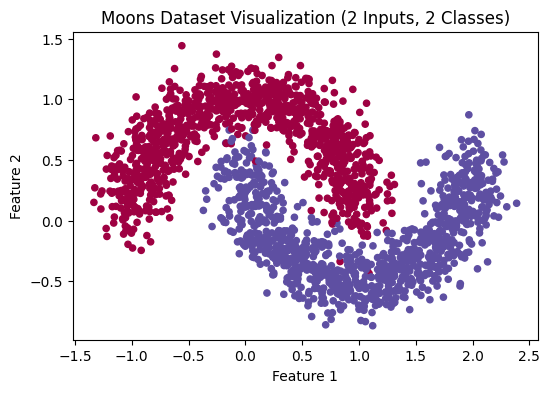

Training MLP (Width: [2, 3, 2])...


| train_loss: 1.41e-01 | test_loss: 1.78e-01 | reg: 4.15e+04 | : 100%|█| 50/50 [00:01<00:00, 41.39it


MLP Final Test Acc: 0.9850
Training KAN (Width: [2, 2], Grid: 50, k: 3)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 0.00e+00 | test_loss: 7.74e-01 | reg: 3.77e+02 | : 100%|█| 50/50 [00:03<00:00, 13.42it


saving model version 0.1
KAN Final Test Acc: 0.9825


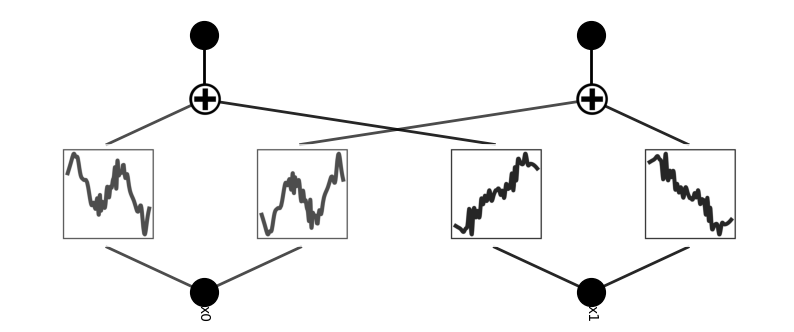

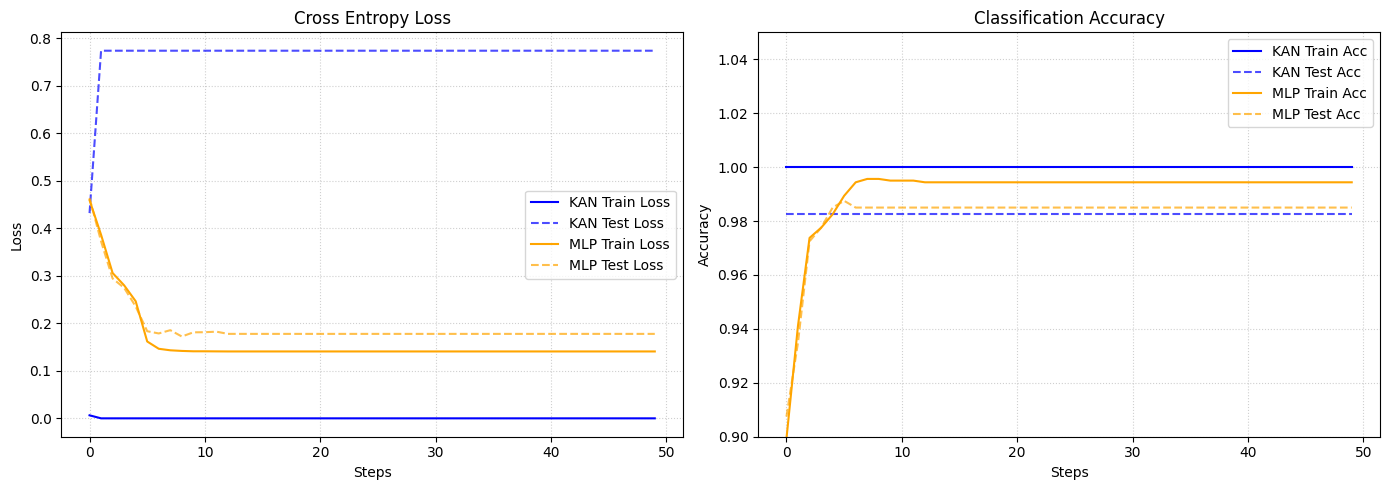

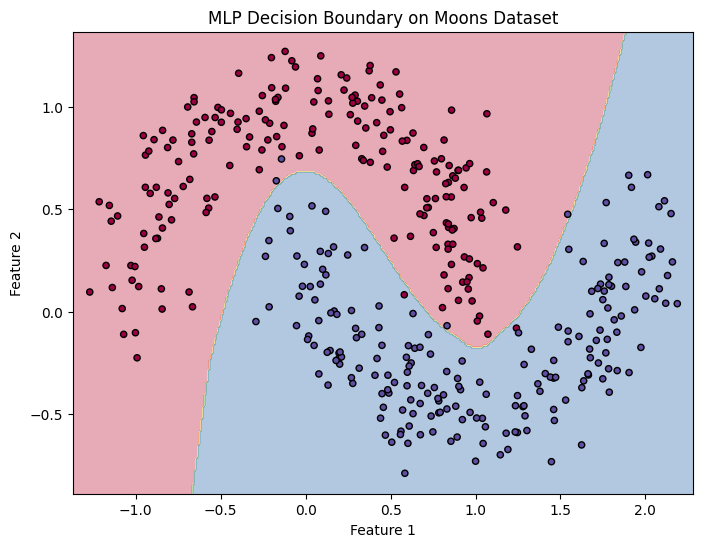

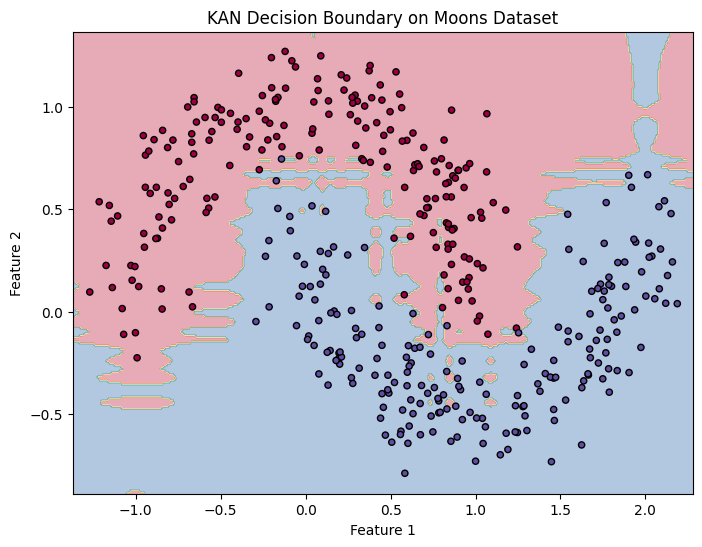

In [2]:
# ==========================================
#               MAIN EXECUTION
# ==========================================

dataset = get_moons_dataset(n_samples=2000, noise=0.15) # Increased samples/noise for a more complex test

mlp_model, mlp_results = train_mlp(dataset,width=[2, 3, 2], steps=50, seed=42)
kan_model, kan_results = train_kan(dataset, width=[2, 2], grid=50, k=3, steps=50, seed=42, cont_training=False)

plot_KAN_graph(kan_model)
plot_comparison(mlp_results, kan_results, min_acc=0.9)

plot_decision_boundary(dataset, mlp_model, 'MLP')
plot_decision_boundary(dataset, kan_model, 'KAN')


In [3]:
#display_formula(kan_model_1)